In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
import certifi

os.environ["SSL_CERT_FILE"] = certifi.where()

ROOT = Path(".").resolve()
DATA_RAW = ROOT / "data_raw"
DATA_PROCESSED = ROOT / "data_processed"
DATA_PROCESSED.mkdir(exist_ok=True)

print("ROOT:", ROOT)

ROOT: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/notebooks


In [3]:
from meteostat import Point
from meteostat.interface.daily import Daily
print("Meteostat ready")

Meteostat ready


In [4]:
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data_raw"
DATA_PROCESSED = ROOT / "data_processed"
DATA_PROCESSED.mkdir(exist_ok=True)

store_info = pd.read_csv(DATA_RAW / "store_info.csv")
perf = pd.read_csv(DATA_RAW / "store_performance_2018to2022.csv")

store_info["store_id"] = store_info["store_id"].astype(int)
perf["store_id"] = perf["store_id"].astype(int)

perf["invoice_date"] = pd.to_datetime(perf["invoice_date"]).dt.normalize()

store_info = store_info[[
    "store_id","store_city","store_state","store_zip",
    "store_latitude","store_longitude"
]].copy()

print("store_info:", store_info.shape)
print("perf:", perf.shape)

store_info: (439, 6)
perf: (773266, 5)


In [5]:
dup_perf = perf.duplicated(["store_id","invoice_date"]).sum()
print("Perf duplicates before:", dup_perf)

if dup_perf > 0:
    perf = (perf.groupby(["store_id","invoice_date"], as_index=False)
              .agg({
                  "invoice_count":"sum",
                  "oc_count":"sum",
                  "fleet_oc_count":"sum"
              }))

print("Perf duplicates after:", perf.duplicated(["store_id","invoice_date"]).sum())

Perf duplicates before: 0
Perf duplicates after: 0


In [6]:
N_STORES = 8

pilot = (
    store_info.dropna(subset=["store_latitude","store_longitude"])
    .merge(perf[["store_id"]].drop_duplicates(), on="store_id", how="inner")
    .drop_duplicates("store_id")
    .sort_values("store_id")
    .head(N_STORES)
    .copy()
)

pilot_ids = pilot["store_id"].tolist()

start_dt = perf["invoice_date"].min().to_pydatetime()
end_dt   = perf["invoice_date"].max().to_pydatetime()

print("Pilot store_ids:", pilot_ids)
print("Date range:", start_dt.date(), "to", end_dt.date())
pilot

Pilot store_ids: [79609, 81958, 83444, 84321, 84328, 84329, 84831, 84832]
Date range: 2018-01-02 to 2022-12-31


,store_id,store_city,store_state,store_zip,store_latitude,store_longitude
0,79609,Lexington,KY,40509,38.01075,-84.45542
239,81958,Lexington,KY,40509,38.01559,-84.41818
127,83444,Lexington,KY,40509,38.00615,-84.45156
1,84321,Lexington,KY,40503,38.00875,-84.51716
128,84328,Lexington,KY,40517,37.96880,-84.50260
240,84329,Lexington,KY,40503,38.00640,-84.57322
241,84831,Frankfort,KY,40601,38.20555,-84.83552
2,84832,Frankfort,KY,40601,38.17055,-84.89900


In [7]:
def fetch_store_weather(lat, lon, start_dt, end_dt):
    p = Point(lat, lon)
    w = Daily(p, start_dt, end_dt).fetch()
    w = w.reset_index().rename(columns={"time":"invoice_date"})
    w["invoice_date"] = pd.to_datetime(w["invoice_date"]).dt.normalize()
    return w

frames = []
for _, r in tqdm(pilot.iterrows(), total=len(pilot), desc="Pulling Meteostat weather"):
    sid = int(r["store_id"])
    lat = float(r["store_latitude"])
    lon = float(r["store_longitude"])

    w = fetch_store_weather(lat, lon, start_dt, end_dt)

    keep = ["invoice_date","tavg","tmin","tmax","prcp","wspd","snow"]
    w = w[[c for c in keep if c in w.columns]].copy()
    w["store_id"] = sid

    frames.append(w)

weather = pd.concat(frames, ignore_index=True)
print("Weather rows:", len(weather))
weather.head()

Pulling Meteostat weather: 100%|██████████| 8/8 [00:00<00:00, 71.95it/s]

Weather rows: 14600


,invoice_date,tavg,tmin,tmax,prcp,wspd,snow,store_id
0,2018-01-02,-13.8,-19.3,-6.6,0.0,5.4,0.0,79609
1,2018-01-03,-9.3,-15.5,-0.5,0.0,13.7,0.0,79609
2,2018-01-04,-7.9,-13.2,-4.9,0.0,16.9,0.0,79609
3,2018-01-05,-11.1,-14.9,-7.1,0.0,9.4,0.0,79609
4,2018-01-06,-12.3,-18.8,-5.5,0.0,4.0,0.0,79609


In [8]:
dup_w = weather.duplicated(["store_id","invoice_date"]).sum()
print("Weather duplicates before:", dup_w)

if dup_w > 0:
    num_cols = [c for c in weather.columns if c not in ["store_id","invoice_date"]]
    weather = weather.groupby(["store_id","invoice_date"], as_index=False)[num_cols].mean()

print("Weather duplicates after:", weather.duplicated(["store_id","invoice_date"]).sum())

Weather duplicates before: 0
Weather duplicates after: 0


In [9]:
perf_pilot = perf[perf["store_id"].isin(pilot_ids)].copy()

merged = perf_pilot.merge(weather, on=["store_id","invoice_date"], how="left")

dup_final = merged.duplicated(["store_id","invoice_date"]).sum()
print("Merged rows:", len(merged))
print("Final duplicates after merge:", dup_final)
assert dup_final == 0, "Duplicates still exist after merge!"

# Missing % quick check
cols = [c for c in ["tmin","tmax","tavg","prcp","wspd","snow"] if c in merged.columns]
if cols:
    print("Missing % weather:")
    print((merged[cols].isna().mean()*100).round(3))

merged.head()

Merged rows: 13827
Final duplicates after merge: 0
Missing % weather:
tmin    0.0
tmax    0.0
tavg    0.0
prcp    0.0
wspd    0.0
snow    0.0
dtype: float64


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tavg,tmin,tmax,prcp,wspd,snow
0,2020-03-17,81958,43,42,11,7.2,4.4,10.6,1.3,8.3,0.0
1,2020-03-14,83444,48,33,0,5.3,1.7,6.7,14.2,18.0,0.0
2,2020-03-20,84321,64,57,4,19.6,5.6,21.7,3.8,24.5,0.0
3,2020-03-06,84832,47,43,1,4.6,2.2,11.1,0.0,20.3,0.0
4,2020-03-05,81958,59,57,4,8.2,1.7,15.6,0.0,15.1,0.0


In [10]:
out_path = DATA_PROCESSED / "merged_model_ready_pilot_meteostat_clean.csv"
merged.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: /Users/jayadeep/GenAI-Weather-Based-Store-Analytics/data_processed/merged_model_ready_pilot_meteostat_clean.csv


In [11]:
import pandas as pd

merged["invoice_date"] = pd.to_datetime(merged["invoice_date"])

merged["dow"] = merged["invoice_date"].dt.dayofweek
merged["month"] = merged["invoice_date"].dt.month
merged["is_weekend"] = (merged["dow"] >= 5).astype(int)

merged["is_rain"] = (merged["prcp"].fillna(0) > 0).astype(int)
merged["is_freezing"] = (merged["tmin"].fillna(99) <= 0).astype(int)

merged.head()

,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tavg,tmin,tmax,prcp,wspd,snow,dow,month,is_weekend,is_rain,is_freezing
0,2020-03-17,81958,43,42,11,7.2,4.4,10.6,1.3,8.3,0.0,1,3,0,1,0
1,2020-03-14,83444,48,33,0,5.3,1.7,6.7,14.2,18.0,0.0,5,3,1,1,0
2,2020-03-20,84321,64,57,4,19.6,5.6,21.7,3.8,24.5,0.0,4,3,0,1,0
3,2020-03-06,84832,47,43,1,4.6,2.2,11.1,0.0,20.3,0.0,4,3,0,0,0
4,2020-03-05,81958,59,57,4,8.2,1.7,15.6,0.0,15.1,0.0,3,3,0,0,0


In [12]:
TARGET = "invoice_count"
SPLIT_YEAR = 2022

train_df = merged[merged["invoice_date"].dt.year < SPLIT_YEAR].copy()
valid_df = merged[merged["invoice_date"].dt.year == SPLIT_YEAR].copy()

print("Target:", TARGET)
print("Train rows:", len(train_df), "| Valid rows:", len(valid_df))
print("Train date range:", train_df["invoice_date"].min(), "to", train_df["invoice_date"].max())
print("Valid date range:", valid_df["invoice_date"].min(), "to", valid_df["invoice_date"].max())
print("Leakage check (train max < valid min):", train_df["invoice_date"].max() < valid_df["invoice_date"].min())

Target: invoice_count
Train rows: 11062 | Valid rows: 2765
Train date range: 2018-01-02 00:00:00 to 2021-12-31 00:00:00
Valid date range: 2022-01-02 00:00:00 to 2022-12-31 00:00:00
Leakage check (train max < valid min): True


In [13]:
baseline_tbl = (
    train_df.groupby(["store_id","dow"])[TARGET]
    .mean()
    .rename("baseline_pred")
    .reset_index()
)

valid_tmp = valid_df.merge(baseline_tbl, on=["store_id","dow"], how="left")
baseline_pred = valid_tmp["baseline_pred"].fillna(train_df[TARGET].mean()).values
y_valid = valid_df[TARGET].astype(float).values

from sklearn.metrics import mean_absolute_error
import numpy as np

baseline_mae = mean_absolute_error(y_valid, baseline_pred)
baseline_mape = np.mean(np.abs((y_valid - baseline_pred) / np.maximum(np.abs(y_valid), 1e-6))) * 100

print("Baseline: store_id + day-of-week mean")
print("MAE :", round(baseline_mae, 2))
print("MAPE:", round(baseline_mape, 3), "%")

Baseline: store_id + day-of-week mean
MAE : 10.46
MAPE: 36186.205 %


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

feature_cols = ["store_id","dow","month","is_weekend","tmin","tmax","tavg","prcp","wspd","snow","is_rain","is_freezing"]
    

X_train = train_df[feature_cols]
y_train = train_df[TARGET].astype(float)

X_valid = valid_df[feature_cols]
y_valid = valid_df[TARGET].astype(float)

categorical = ["store_id"]
numeric = [c for c in feature_cols if c not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
])

pipe = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0)),
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_valid)
pred[:5]

array([58.32457089, 41.75779626, 39.37847075, 60.98321422, 40.94375033])

In [15]:
ridge_mae = mean_absolute_error(y_valid, pred)
ridge_mape = np.mean(np.abs((y_valid - pred) / np.maximum(np.abs(y_valid), 1e-6))) * 100

print("Ridge Prototype")
print("MAE :", round(ridge_mae, 2))
print("MAPE:", round(ridge_mape, 3), "%")

print("\nImprovement vs Baseline (positive = better):")
print("MAE improvement:", round(baseline_mae - ridge_mae, 2))
print("MAPE improvement:", round(baseline_mape - ridge_mape, 3), "%")

Ridge Prototype
MAE : 11.28
MAPE: 1845268.256 %

Improvement vs Baseline (positive = better):
MAE improvement: -0.82
MAPE improvement: -1809082.05 %


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def safe_mape(y_true, y_pred, min_true=1.0):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true >= min_true   # ignore zeros/small counts
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Baseline metrics
baseline_mae = mean_absolute_error(y_valid, baseline_pred)
baseline_mape_safe = safe_mape(y_valid, baseline_pred, min_true=1.0)

# Ridge metrics
ridge_mae = mean_absolute_error(y_valid, pred)
ridge_mape_safe = safe_mape(y_valid, pred, min_true=1.0)

print("Baseline MAE:", round(baseline_mae,2), "| safeMAPE:", round(baseline_mape_safe,2), "%")
print("Ridge    MAE:", round(ridge_mae,2), "| safeMAPE:", round(ridge_mape_safe,2), "%")

print("Count of zero invoice days in validation:", int((np.array(y_valid)==0).sum()))

Baseline MAE: 10.46 | safeMAPE: 19.85 %
Ridge    MAE: 11.28 | safeMAPE: 20.81 %
Count of zero invoice days in validation: 2


In [17]:
import numpy as np
import pandas as pd

df = merged.copy()
df = df.sort_values(["store_id", "invoice_date"]).reset_index(drop=True)

# Calendar / seasonality
df["dow"] = df["invoice_date"].dt.dayofweek
df["month"] = df["invoice_date"].dt.month
df["day_of_year"] = df["invoice_date"].dt.dayofyear
df["year"] = df["invoice_date"].dt.year
df["is_weekend"] = (df["dow"] >= 5).astype(int)

# "Seasons" (simple buckets)
def season(m):
    if m in (12, 1, 2): return "winter"
    if m in (3, 4, 5):  return "spring"
    if m in (6, 7, 8):  return "summer"
    return "fall"
df["season"] = df["month"].apply(season)

# Trend per store (monotonic time index)
df["time_index"] = df.groupby("store_id").cumcount()

# Weather flags + intensity (NaN-safe)
df["is_rain"] = (df["prcp"].fillna(0) > 0).astype(int)
df["is_snow"] = (df["snow"].fillna(0) > 0).astype(int)
df["is_freezing"] = (df["tmin"].fillna(99) <= 0).astype(int)

# Intensity buckets (help non-linear effect even for linear model)
df["rain_mm"] = df["prcp"].fillna(0)
df["snow_cm"] = df["snow"].fillna(0)

df["heavy_rain"] = (df["rain_mm"] >= 10).astype(int)    # 10mm+ in a day
df["heavy_snow"] = (df["snow_cm"] >= 5).astype(int)     # 5cm+ in a day

# Temperature range (often useful)
df["temp_range"] = (df["tmax"] - df["tmin"])

df.head()

,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,tavg,tmin,tmax,prcp,wspd,...,day_of_year,year,season,time_index,is_snow,rain_mm,snow_cm,heavy_rain,heavy_snow,temp_range
0,2018-01-02,79609,47,39,2,-13.8,-19.3,-6.6,0.0,5.4,...,2,2018,winter,0,0,0.0,0.0,0,0,12.7
1,2018-01-03,79609,46,40,8,-9.3,-15.5,-0.5,0.0,13.7,...,3,2018,winter,1,0,0.0,0.0,0,0,15.0
2,2018-01-04,79609,43,38,6,-7.9,-13.2,-4.9,0.0,16.9,...,4,2018,winter,2,0,0.0,0.0,0,0,8.3
3,2018-01-05,79609,45,30,2,-11.1,-14.9,-7.1,0.0,9.4,...,5,2018,winter,3,0,0.0,0.0,0,0,7.8
4,2018-01-06,79609,39,32,0,-12.3,-18.8,-5.5,0.0,4.0,...,6,2018,winter,4,0,0.0,0.0,0,0,13.3


In [18]:
TARGET = "invoice_count"

# helper to create lag/rolling safely per store
def add_lag_roll(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("invoice_date").copy()

    # Demand lags (past invoices)
    g["inv_lag_1"] = g[TARGET].shift(1)
    g["inv_lag_7"] = g[TARGET].shift(7)

    # Rolling mean of past demand (shifted so it uses only past)
    g["inv_roll7_mean"] = g[TARGET].shift(1).rolling(7, min_periods=3).mean()
    g["inv_roll14_mean"] = g[TARGET].shift(1).rolling(14, min_periods=5).mean()

    # Weather lags
    for col in ["tavg","prcp","snow","wspd"]:
        if col in g.columns:
            g[f"{col}_lag_1"] = g[col].shift(1)
            g[f"{col}_lag_7"] = g[col].shift(7)
            g[f"{col}_roll7_mean"] = g[col].shift(1).rolling(7, min_periods=3).mean()

    return g

df = df.groupby("store_id", group_keys=False).apply(add_lag_roll)

df[["store_id","invoice_date",TARGET,"inv_lag_1","inv_roll7_mean","prcp","prcp_lag_1","prcp_roll7_mean"]].head(15)

,store_id,invoice_date,invoice_count,inv_lag_1,inv_roll7_mean,prcp,prcp_lag_1,prcp_roll7_mean
0,79609,2018-01-02,47,NaN,NaN,0.0,NaN,NaN
1,79609,2018-01-03,46,47.0,NaN,0.0,0.0,NaN
2,79609,2018-01-04,43,46.0,NaN,0.0,0.0,NaN
3,79609,2018-01-05,45,43.0,45.333333,0.0,0.0,0.000000
4,79609,2018-01-06,39,45.0,45.250000,0.0,0.0,0.000000
5,79609,2018-01-07,25,39.0,44.000000,0.0,0.0,0.000000
6,79609,2018-01-08,38,25.0,40.833333,7.1,0.0,0.000000
7,79609,2018-01-09,39,38.0,40.428571,0.0,7.1,1.014286
8,79609,2018-01-10,45,39.0,39.285714,0.0,0.0,1.014286
9,79609,2018-01-11,51,45.0,39.142857,2.3,0.0,1.014286


In [19]:
SPLIT_YEAR = 2022
train_df = df[df["invoice_date"].dt.year < SPLIT_YEAR].copy()
valid_df = df[df["invoice_date"].dt.year == SPLIT_YEAR].copy()

print("Train rows:", len(train_df), "Valid rows:", len(valid_df))
print("Train dates:", train_df["invoice_date"].min(), "to", train_df["invoice_date"].max())
print("Valid dates:", valid_df["invoice_date"].min(), "to", valid_df["invoice_date"].max())
print("Leakage check:", train_df["invoice_date"].max() < valid_df["invoice_date"].min())

# optional: drop rows where lag features are missing (early days)
# keep it minimal to avoid losing too much data
lag_cols = [c for c in train_df.columns if "lag_" in c or "roll" in c]
print("Lag/Roll cols:", len(lag_cols))

Train rows: 11062 Valid rows: 2765
Train dates: 2018-01-02 00:00:00 to 2021-12-31 00:00:00
Valid dates: 2022-01-02 00:00:00 to 2022-12-31 00:00:00
Leakage check: True
Lag/Roll cols: 16


In [20]:
# --- GUARD CELL: make sure required feature columns exist ---
import pandas as pd
import numpy as np

# Make sure df exists (if you named it merged, switch df = merged.copy())
try:
    df
except NameError:
    df = merged.copy()

df["invoice_date"] = pd.to_datetime(df["invoice_date"])

# Ensure month exists
if "month" not in df.columns:
    df["month"] = df["invoice_date"].dt.month

# Ensure season exists
def season_from_month(m):
    if m in (12, 1, 2): return "winter"
    if m in (3, 4, 5):  return "spring"
    if m in (6, 7, 8):  return "summer"
    return "fall"

if "season" not in df.columns:
    df["season"] = df["month"].apply(season_from_month)

print("season added/confirmed. Columns now include season =", "season" in df.columns)
df[["invoice_date","month","season"]].head()

season added/confirmed. Columns now include season = True


,invoice_date,month,season
0,2018-01-02,1,winter
1,2018-01-03,1,winter
2,2018-01-04,1,winter
3,2018-01-05,1,winter
4,2018-01-06,1,winter


In [21]:
print("train_df has season?", "season" in train_df.columns)
print("X_train columns preview:", list(train_df.columns)[:25])

train_df has season? True
X_train columns preview: ['invoice_date', 'store_id', 'invoice_count', 'oc_count', 'fleet_oc_count', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'snow', 'dow', 'month', 'is_weekend', 'is_rain', 'is_freezing', 'day_of_year', 'year', 'season', 'time_index', 'is_snow', 'rain_mm', 'snow_cm', 'heavy_rain', 'heavy_snow']


In [22]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

TARGET = "invoice_count"

# Build features (NO season)
base = ["store_id","dow","month","day_of_year","year","is_weekend","time_index"]
weather_now = ["tmin","tmax","tavg","prcp","wspd","snow","temp_range",
               "is_rain","is_snow","is_freezing","heavy_rain","heavy_snow",
               "rain_mm","snow_cm"]

lags_rolls = [c for c in train_df.columns if c.startswith(("inv_lag","inv_roll","tavg_lag","tavg_roll",
                                                          "prcp_lag","prcp_roll","snow_lag","snow_roll",
                                                          "wspd_lag","wspd_roll"))]

feature_cols = [c for c in (base + weather_now + lags_rolls) if c in train_df.columns]

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET].astype(float)

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df[TARGET].astype(float)

categorical = ["store_id"]
numeric = [c for c in feature_cols if c not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
])

model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_valid)

def safe_mape(y_true, y_pred, min_true=1.0):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true >= min_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae = mean_absolute_error(y_valid, pred)
mape = safe_mape(y_valid, pred)

print("RandomForest Prototype (v1 features, no season)")
print("MAE :", round(mae, 2))
print("safeMAPE:", round(mape, 2), "%")

RandomForest Prototype (v1 features, no season)
MAE : 7.96
safeMAPE: 17.08 %


In [23]:
import joblib, json
from pathlib import Path
import pandas as pd

DATA_PROCESSED = Path("data_processed")
REPORTS = Path("reports")
DATA_PROCESSED.mkdir(exist_ok=True)
REPORTS.mkdir(exist_ok=True)

# Save model
joblib.dump(pipe, DATA_PROCESSED / "model.joblib")

# Save predictions
pred_out = valid_df[["store_id","invoice_date",TARGET]].copy()
pred_out.rename(columns={TARGET:"y_true"}, inplace=True)
pred_out["y_pred"] = pred
pred_out.to_csv(DATA_PROCESSED / "predictions.csv", index=False)

# Save metrics (include baseline too)
metrics = {
    "baseline": {"mae": 10.46, "safe_mape": 19.85},
    "random_forest_v1": {"mae": float(mae), "safe_mape": float(mape)},
    "split": "train=2018-2021, valid=2022",
    "pilot_store_ids": sorted(valid_df["store_id"].unique().tolist()),
    "n_train": int(len(train_df)),
    "n_valid": int(len(valid_df)),
    "n_features": int(len(feature_cols)),
    "feature_cols": feature_cols
}
(REPORTS / "metrics.json").write_text(json.dumps(metrics, indent=2))

print("Saved data_processed/model.joblib")
print("Saved data_processed/predictions.csv")
print("Saved reports/metrics.json")
pred_out.head()

Saved data_processed/model.joblib
Saved data_processed/predictions.csv
Saved reports/metrics.json


,store_id,invoice_date,y_true,y_pred
1432,79609,2022-01-02,37,32.497022
1433,79609,2022-01-03,60,52.588088
1434,79609,2022-01-04,62,57.516847
1435,79609,2022-01-05,52,57.409154
1436,79609,2022-01-06,16,51.583912


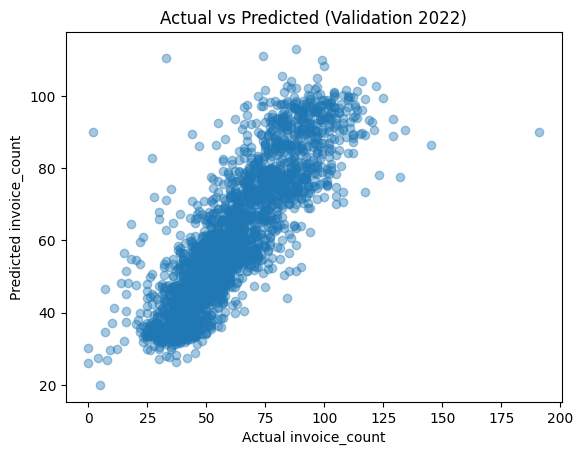

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_valid, pred, alpha=0.4)
plt.xlabel("Actual invoice_count")
plt.ylabel("Predicted invoice_count")
plt.title("Actual vs Predicted (Validation 2022)")
plt.show()

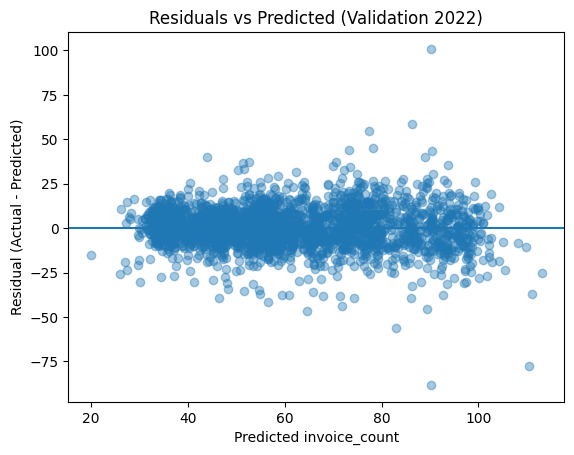

In [25]:
residuals = y_valid - pred

plt.figure()
plt.scatter(pred, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Predicted invoice_count")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Validation 2022)")
plt.show()

In [50]:
import pandas as pd
err_df = pd.DataFrame({
    "store_id": valid_df["store_id"].values,
    "invoice_date": valid_df["invoice_date"].values,
    "actual": y_valid,
    "pred": pred,
})
err_df["abs_error"] = (err_df["actual"] - err_df["pred"]).abs()
err_df.sort_values("abs_error", ascending=False).head(2765)

,store_id,invoice_date,actual,pred,abs_error
7029,84321,2022-08-19,191.0,90.142195,100.857805
7154,84321,2022-12-24,2.0,90.141605,88.141605
6807,84321,2022-01-06,33.0,110.455718,77.455718
7124,84321,2022-11-23,145.0,86.322445,58.677555
6836,84321,2022-02-04,27.0,82.942564,55.942564
...,...,...,...,...,...
13668,84832,2022-06-24,49.0,49.048013,0.048013
5207,83444,2022-07-18,55.0,55.039706,0.039706
5189,83444,2022-06-29,57.0,57.033052,0.033052
6899,84321,2022-04-08,90.0,90.010902,0.010902
